# Linear Regression: traditional vs Bayesian Ways

Ref: https://marcelhaas.com/LinearRegression3ways.html

In [2]:
import sys
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and machine learning
import statsmodels.api as sm


# Bayesian statistics
import pymc as pm
import arviz as az

# Some plotting styles
# %config InlineBackend.figure_format = 'retina'
# az.style.use('arviz-darkgrid')

In [3]:
# Parameters about the data:
size = 20   # number of data points
true_intercept = 4
true_slope = 6

# Create the independent variable
x = np.linspace(0, 1, size)
# Create the independent variable y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise, drawn from a Gaussian (from numpy) with mean 0 and a standard deviation of 0.5
np.random.seed(123)
y = true_regression_line + np.random.normal(scale=.5, size=size)

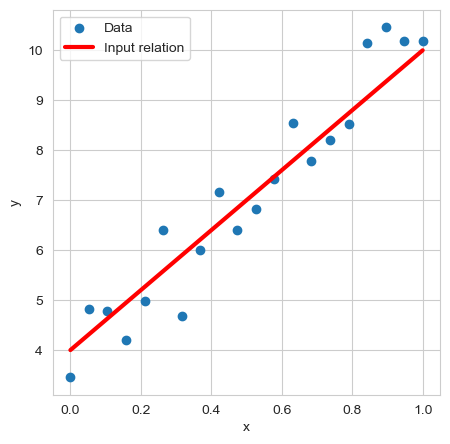

In [4]:
# Here's what it looks like (plotted the matplotlib interactive way)
plt.figure(figsize=(5,5))
plt.scatter(x, y, label='Data')
plt.plot(x, true_regression_line, color='red', linewidth=3, label='Input relation')
plt.legend()
plt.xlabel('x'); plt.ylabel('y');

In [5]:
# Statsmodels requires one to specify the extra constant that needs to be fitted and can then fit using Ordinary Least Squares
X = sm.add_constant(x, prepend=True)
smreg = sm.OLS(y, X)
smres = smreg.fit()
# After fitting, an extensive summary of fit results can be produced.
print(smres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     234.4
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           9.16e-12
Time:                        20:09:33   Log-Likelihood:                -17.074
No. Observations:                  20   AIC:                             38.15
Df Residuals:                      18   BIC:                             40.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6792      0.258     14.254      0.0

In [6]:
with pm.Model() as linreg: # model specifications in PyMC are wrapped in a context
    # Define priors
    # These priors are pretty uninformative: wide distributions without any peaks, the stochastic variables can be anywhere
    # They are defined using PyMC\ defined probability distribution functions (and corresponding parameters) and they get a name
    
    # The intercept and the slope can both be positive or negative, and we don't know their value yet
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('Slope', 0, sigma=20)
    # The data generating process is such that we have the linear relationship with scatter, so
    # the scatter also needs to be part of the model. We model it as Gaussian, with zero mean
    # and a positive standard deviation that is not yet well constrained
    sigma = pm.HalfCauchy('sigma', beta=10)

    # Define a likelihood: a PDF as well, that depends on the stochastic variables for which you defined a prior
    # The observed=-keyword specifies that this is the observed data that is being described by the model
    # The likelihood is Gaussian, as we said above, with a mean given by the linear relation we are after
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sigma=sigma, observed=y)

    # The line below does inference! The posterior PDF will be sampled
    trace = pm.sample(2000, cores=2, tune=2000, return_inferencedata=True, ) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Slope, sigma]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  3.678  0.278   3.173    4.207      0.007    0.005    1463.0   
Slope      6.761  0.478   5.848    7.644      0.013    0.009    1435.0   
sigma      0.645  0.118   0.448    0.867      0.003    0.002    2030.0   

           ess_tail  r_hat  
Intercept    1861.0    1.0  
Slope        1896.0    1.0  
sigma        1519.0    1.0  


<Figure size 200x200 with 0 Axes>

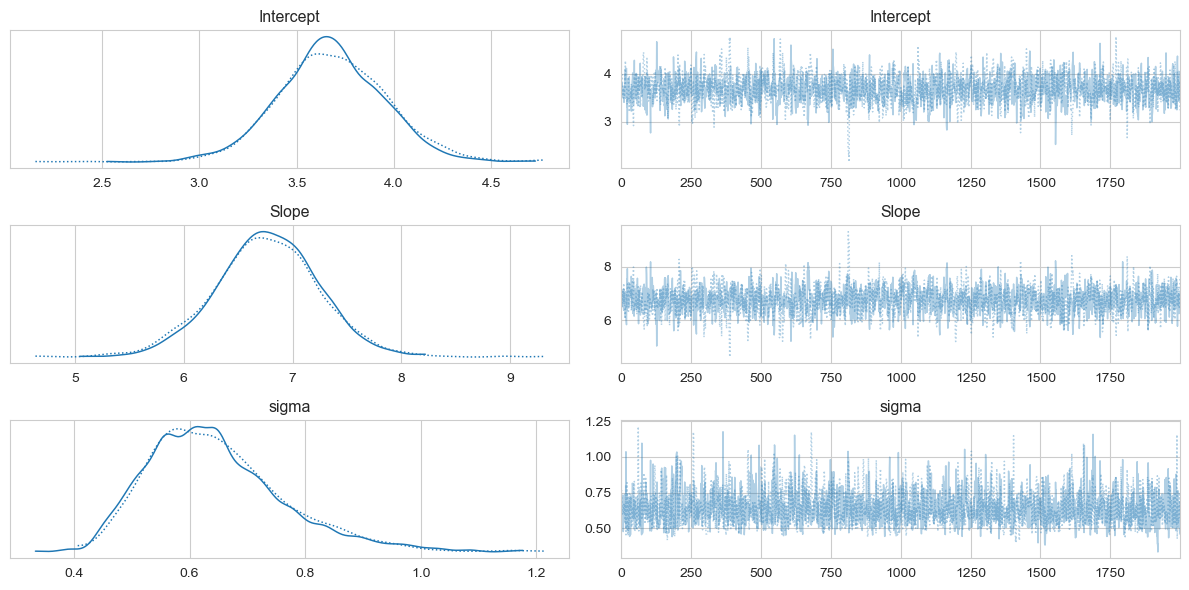

In [7]:
# We can get basic statistics of the posterior like this:
print(pm.summary(trace)) # A summary of the results for all stochastic variables

# Plotting functionality for traces is provided by the package Arviz
plt.figure(figsize=(2,2))
az.plots.traceplot.plot_trace(trace)  
plt.tight_layout()

## In addition to coefficients and its standard error, we also get to see the full shape of distributions